### __Импорт библиотек__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

### __Подготовка данных__

In [3]:
columns = [
    'Vehicle Name', 'Sports Car?', 'SUV?', 'Wagon?', 'Minivan?', 'Pickup?', 'AWD?', 'RWD?',
    'Suggested Retail Price', 'Dealer Cost', 'Engine Size', 'Number of Cylinders', 'Horsepower', 
    'City MPG', 'Highway MPG', 'Weight', 'Wheel Base', 'Length', 'Width'
    ]

# Загрузка данных
raw_data = pd.read_csv('10_2004 New_Car_and_Truck_Data_SportsCar/04cars.dat', delimiter=';', header=None, names=columns)

# Предобработка данных
raw_data.drop(columns=raw_data.columns[0], axis=1, inplace=True)  # Удаление столбца с именем автомобиля

# Проверка на наличие NaN и заполнение пропусков
raw_data.fillna(raw_data.mean(), inplace=True)

car_types_count = raw_data[['Sports Car?', 'SUV?', 'Wagon?', 'Minivan?', 'Pickup?']].sum()

# Вывод результата
print(car_types_count)

# Выбор необходимых столбцов и фильтрация по "Sports Car?"
features = ['Engine Size', 'Horsepower', 'Weight', 'Wheel Base', 'Length', 'Width']

x = raw_data[features]
y = raw_data['Sports Car?']  # Целевая переменная - является ли автомобиль спортивным (1 - да, 0 - нет)


Sports Car?    49
SUV?           60
Wagon?         30
Minivan?       20
Pickup?        24
dtype: int64


### __Разделение выборки__

In [10]:
# Стратифицированное разделение на обучающую и тестовую выборки, чтобы сохранить пропорции спорткаров
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(
    x, y, test_size=0.45, random_state=0, stratify=y
)

# Масштабирование признаков (стандартизация)
scaler = StandardScaler()
x_training_data = scaler.fit_transform(x_training_data)
x_test_data = scaler.transform(x_test_data)

### __SMOTE__

In [11]:
smote = SMOTE(random_state=0)
x_train_balanced, y_train_balanced = smote.fit_resample(x_training_data, y_training_data)

print(f'Размер тренировочного набора: {x_train_balanced.shape}, {y_train_balanced.shape}')
print(f'Размер тестового набора: {x_test_data.shape}, {y_test_data.shape}')

Размер тренировочного набора: (416, 6), (416,)
Размер тестового набора: (193, 6), (193,)


### __Поиск наилучшего значения k__

In [12]:
best_k = None
best_accuracy = 0
error_rates = []

for k in range(1, 51):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train_balanced, y_train_balanced)
    new_predictions = model.predict(x_test_data)
    accuracy = accuracy_score(y_test_data, new_predictions)
    error_rates.append(np.mean(new_predictions != y_test_data))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

best_k = 35
print("Наилучшее значение k:", best_k)

Наилучшее значение k: 35


### __Обучение модели с наилучшим k__

In [17]:
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train_balanced, y_train_balanced)
predictions = model.predict(x_test_data)

 ### __Оценка качества модели и процента ошибок__

In [18]:
matrix = confusion_matrix(y_test_data, predictions)
print("Таблица сопряженности:")
print(matrix)

error_rate = 1 - accuracy_score(y_test_data, predictions)
print("Процент ошибок:", f"{error_rate * 100:.2f}%")

Таблица сопряженности:
[[161  10]
 [  3  19]]
Процент ошибок: 6.74%


### __Графики__

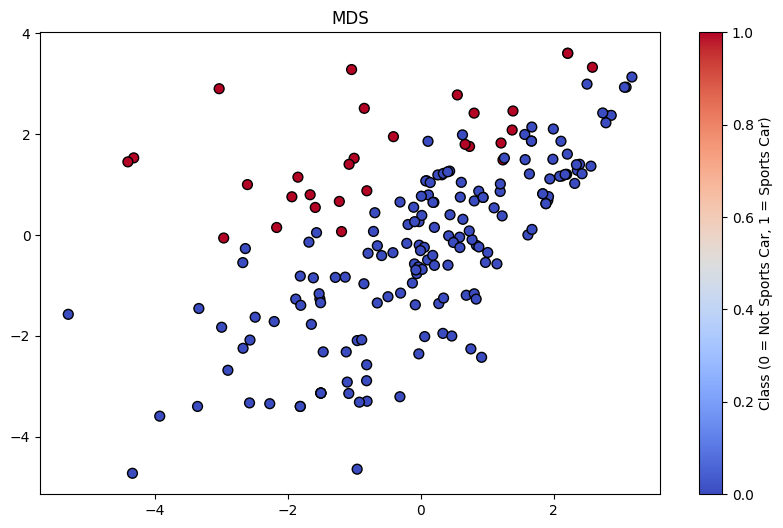

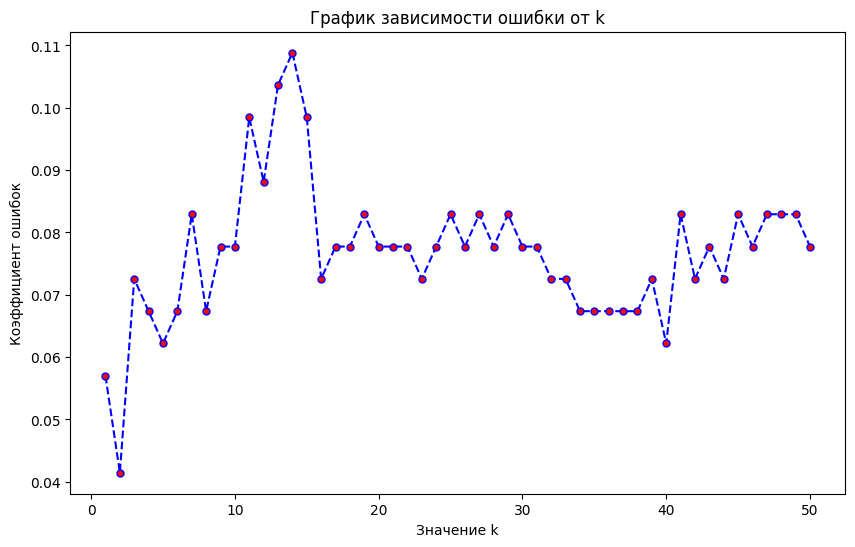

In [20]:
# Визуализация многомерного шкалирования (MDS) после предсказаний
mds = MDS(n_components=2, random_state=0)
mds_transformed = mds.fit_transform(x_test_data)

plt.figure(figsize=(10,6))
# Используем предсказанные значения для окрашивания
plt.scatter(mds_transformed[:, 0], mds_transformed[:, 1], c=predictions, cmap='coolwarm', s=50, edgecolor='k')
plt.colorbar(label='Class (0 = Not Sports Car, 1 = Sports Car)')
plt.title('MDS')
plt.show()

# График зависимости ошибки от k
plt.figure(figsize=(10,6))
plt.plot(range(1, 51), error_rates, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=5)
plt.title('График зависимости ошибки от k')
plt.xlabel('Значение k')
plt.ylabel('Коэффициент ошибок')
plt.show()